# Lesson 1 - Keras implementation of fast ai part 1 v2
- This is a Keras implementation of Jeremy Howard's fastai part 1 v2 lesson 1 (original version is in PyTorch)
- This has only been tested with the TensorFlow backend to Keras

In [1]:
%matplotlib inline
from utils import *
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


Loading in Keras' off the shelf/pretrained ResNet50 model.

***note: the PyTorch course uses ResNet34. After many hours spent writing code to convert PyTorch models and weights into Keras. I opted to use Keras' ResNet50.***

In [2]:
model = ResNet50()

finetune2() removes the dense layers and final pooling layer and replaces them with:
- An Average and Max Pooling Layer concatenated together
- Adds Batchnormalization
- Adds Dropout
- Adds Dense layers to predict num_classes

it also freezes all convolutional layers

In [3]:
# pool_layer = [layer for layer in model.layers if layer.name == 'avg_pool'][0]
# model = finetune2(model,pool_layer,2)

In [3]:
model = finetune(model,2)

We will use the dogs and cats dataset

path should be replaced with the path to your downloaded dogs and cats dataset

For the original Keras dogs/cats lesson1 and instructions on downloading visit:
https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb

In [4]:
path="/home/jeff/projects/fastai/data/dogscats/" #update with your path to cats and dogs
batch_size = 64

In [5]:
batches = ImageDataGenerator().flow_from_directory(path+'train', target_size=(224,224),
                class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [6]:
val_batches = ImageDataGenerator().flow_from_directory(path+'valid', target_size=(224,224),
                class_mode='categorical', shuffle=False, batch_size=batch_size*4)

Found 2000 images belonging to 2 classes.


The LR_Find callback is utilized to find a good starting learning rate

In [7]:
epochs = 1
callback_list = []
lr_find = LR_Find(math.ceil(batches.samples/batch_size),jump=5)
callback_list.append(lr_find)

In [8]:
sgd = optimizers.SGD(lr=1e-05, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=sgd)

In [9]:
model.fit_generator(batches, steps_per_epoch=math.ceil(batches.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list,
                   )

Epoch 1/1
274/360 [=====================>........] - ETA: 15s - loss: 0.6177

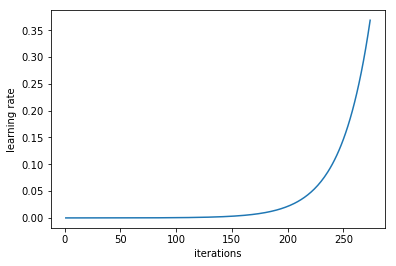

In [10]:
lr_find.plot_lr()

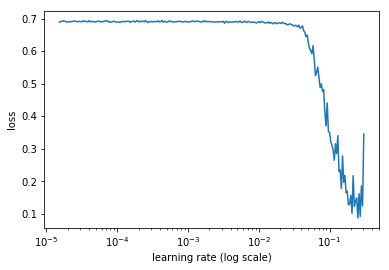

In [11]:
lr_find.plot()

As you can see in the plot above it appears the optimal learning rate to set is .08

**Data Augmentation on the training data**

Now time to start training!  I noticed that the pretrained Keras ResNet50 model is not quite as accurate in my opinion as the pretrained PyTorch ResNet50 model.

In [12]:
#random whitening
batches_aug = ImageDataGenerator(rotation_range=10, zoom_range=1.1, horizontal_flip=True).flow_from_directory(path+'train', target_size=(224,224),
                class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [13]:
epochs = 4
callback_list = []
sgd = optimizers.SGD(lr=.08)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [14]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list, 
                   )

Epoch 1/4
360/360 [==============================] - 147s - loss: 0.6015 - acc: 0.6901   
Epoch 2/4
360/360 [==============================] - 149s - loss: 0.3849 - acc: 0.8251   
Epoch 3/4
360/360 [==============================] - 148s - loss: 0.3600 - acc: 0.8274   
Epoch 4/4
360/360 [==============================] - 147s - loss: 0.3419 - acc: 0.8361   


Evaluate function may run a little slow.  I find that Keras generator's are not the fastest compared to the ones in the fastai PyTorch library.  Generally I try to load the entire dataset into memory, but since this repository is meant to be shared I opted for generators so that it works for a wider audience.

In [15]:
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

[0.11414361582578296, 0.96329923273657292]

Fit for 3 epochs with a Cyclical Learning Rate

In [17]:
epochs = 3
callback_list = []
lr_cycle = LR_Cycle(math.ceil(batches_aug.samples/batch_size), cycle_mult=2)
callback_list.append(lr_cycle)

In [18]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list, 
                   )

Epoch 1/3
360/360 [==============================] - 146s - loss: 0.3309 - acc: 0.8394   
Epoch 2/3
360/360 [==============================] - 147s - loss: 0.3235 - acc: 0.8449   
Epoch 3/3
360/360 [==============================] - 145s - loss: 0.3071 - acc: 0.8549   


In [19]:
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

[0.082253341866489194, 0.97790727623906293]

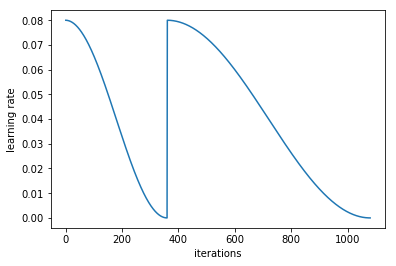

In [20]:
lr_cycle.plot_lr()

In [21]:
model.save('keras_resnet50.hdf5')

Make all layers trainable

In [26]:
for layer in model.layers: layer.trainable = True

In [27]:
callbacks = []
epochs = 7
lr_cycle = LR_Cycle(math.ceil(batches.samples/batch_size), cycle_len=1, cycle_mult=2, epochs=epochs)
callbacks.append(lr_cycle)

SGD2 is a modified version of Keras' SGD that accepts multiple learning rates for different parts of the model.  It accepts an early layer and then a later layer at which to start using the 2nd and 3rd learning rates

In [28]:
conv_layer = [layer for layer in model.layers if layer.name == 'res4a_branch2a'][0]
# fc_layer = [layer for layer in model.layers if layer.name == 'start_flat'][0] #use with finetune2
fc_layer = [layer for layer in model.layers if layer.name == 'fc1000'][0] #use with finetune1
sgd = SGD2(conv_layer, fc_layer, lr=[0.0001, .001, .01])
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [29]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), epochs=epochs, 
                        callbacks=callbacks, 
#                         validation_data=val_batches, 
#                         validation_steps=val_batches.samples
                       )

Epoch 1/7
360/360 [==============================] - 204s - loss: 0.3060 - acc: 0.8513   
Epoch 2/7
360/360 [==============================] - 203s - loss: 0.3001 - acc: 0.8551   
Epoch 3/7
360/360 [==============================] - 203s - loss: 0.2917 - acc: 0.8643   
Epoch 4/7
360/360 [==============================] - 203s - loss: 0.2921 - acc: 0.8607   
Epoch 5/7
360/360 [==============================] - 203s - loss: 0.2798 - acc: 0.8668   
Epoch 6/7
360/360 [==============================] - 203s - loss: 0.2735 - acc: 0.8726   
Epoch 7/7
360/360 [==============================] - 203s - loss: 0.2732 - acc: 0.8697   


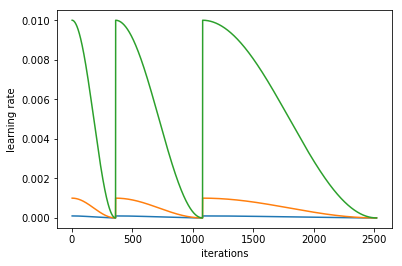

In [30]:
lr_cycle.plot_lr()

In [31]:
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

[0.066375320760120995, 0.98290215365466527]

In [34]:
sgd = optimizers.SGD(lr=.08)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
#note have to recompile in order to save. save function doesn't like multiple lr's :(
model.save('keras_resnet50_2.hdf5')